In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import skew, kurtosis
from scipy.fft import fft

### 显示中文

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 

matplotlib.rcParams['axes.unicode_minus'] = False

In [ ]:
attachment1_file = 'D:\\AAALearn\\2024数学建模\\2024年中国研究生数学建模竞赛赛题\\C\\附件一（训练集）.xlsx'

sheet_names = ['材料1', '材料2', '材料3', '材料4']


material_models = {}
material_scalers = {}
material_core_loss = {}

# 提取磁通密度特征
def extract_features(df):
    features = pd.DataFrame()
    flux_density = df.iloc[:, 4:].values
    
    # 基础特征
    features['Mean'] = np.mean(flux_density, axis=1)  
    features['Std'] = np.std(flux_density, axis=1)
    features['Max'] = np.max(flux_density, axis=1)
    features['Min'] = np.min(flux_density, axis=1)
    features['Peak-to-Peak'] = features['Max'] - features['Min']
    features['Skewness'] = skew(flux_density, axis=1)
    features['Kurtosis'] = kurtosis(flux_density, axis=1)
    features['Zero_Crossing_Rate'] = ((np.diff(np.sign(flux_density)) != 0).sum(axis=1)) / flux_density.shape[1]
    
    # 傅里叶变换（FFT）： 提取频谱特征
    fft_vals = np.abs(fft(flux_density))
    features['FFT_Max'] = np.max(fft_vals[:, 1:], axis=1)
    features['FFT_Mean'] = np.mean(fft_vals[:, 1:], axis=1)
    features['FFT_Std'] = np.std(fft_vals[:, 1:], axis=1)
    
    # 一阶差分的特征
    diff = np.diff(flux_density, axis=1)
    features['Diff_Mean'] = np.mean(diff, axis=1)
    features['Diff_Std'] = np.std(diff, axis=1)
    features['Diff_Max'] = np.max(diff, axis=1)
    features['Diff_Min'] = np.min(diff, axis=1)
    
    # 原始基础数据
    features['Temperature'] = df.iloc[:, 0].values
    features['Frequency'] = df.iloc[:, 1].values
    features['Core_Loss'] = df.iloc[:, 2].values 
    
    # 标签
    wave_dict = {'正弦波': 1, '三角波': 2, '梯形波': 3}
    features['Waveform'] = df.iloc[:, 3].map(wave_dict)
    
    return features

###  遍历每个材料并训练模型，再将训练好的模型储存


正在处理 材料1 ...

材料1 的分类报告：
              precision    recall  f1-score   support

         正弦波       1.00      1.00      1.00       213
         三角波       1.00      1.00      1.00       283
         梯形波       1.00      1.00      1.00       184

    accuracy                           1.00       680
   macro avg       1.00      1.00      1.00       680
weighted avg       1.00      1.00      1.00       680



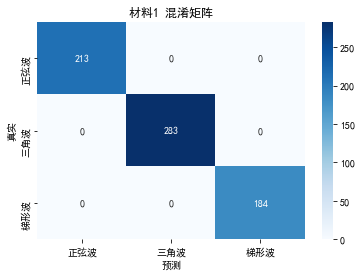


正在处理 材料2 ...

材料2 的分类报告：
              precision    recall  f1-score   support

         正弦波       1.00      1.00      1.00       219
         三角波       1.00      1.00      1.00       201
         梯形波       1.00      1.00      1.00       180

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



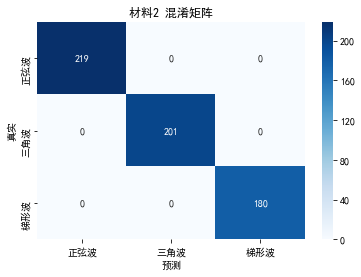


正在处理 材料3 ...

材料3 的分类报告：
              precision    recall  f1-score   support

         正弦波       1.00      1.00      1.00       202
         三角波       1.00      1.00      1.00       216
         梯形波       1.00      1.00      1.00       222

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640



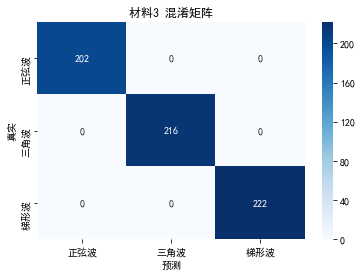


正在处理 材料4 ...

材料4 的分类报告：
              precision    recall  f1-score   support

         正弦波       1.00      1.00      1.00       176
         三角波       1.00      1.00      1.00       291
         梯形波       1.00      1.00      1.00        93

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



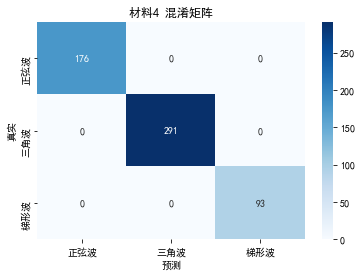

In [14]:
for sheet in sheet_names:
    material_name = sheet
    print(f"\n正在处理 {material_name} ...")

    df = pd.read_excel(attachment1_file, sheet_name=sheet)
    features = extract_features(df)
    avg_core_loss = features['Core_Loss'].mean()
    material_core_loss[material_name] = avg_core_loss
    X = features.drop(['Waveform'], axis=1)
    y = features['Waveform']
    
    # 分割训练集和验证集
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()     # 将自己变量特征进行标准化处理
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # 根据数据特征，选择随机森林进行预测
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_val_scaled)
    
    # 分类报告
    print(f"\n{material_name} 的分类报告：")
    print(classification_report(y_val, y_pred, target_names=['正弦波', '三角波', '梯形波']))
    
    # 显示预测效果
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['正弦波', '三角波', '梯形波'],
                yticklabels=['正弦波', '三角波', '梯形波'])
    plt.xlabel('预测')
    plt.ylabel('真实')
    plt.title(f'{material_name} 混淆矩阵')
    plt.show()
    
    material_models[material_name] = clf
    material_scalers[material_name] = scaler


### 根据已训练的模型对附件二的数据进行预测

In [17]:
attachment2_file = 'D:\\AAALearn\\2024数学建模\\2024年中国研究生数学建模竞赛赛题\\C\\附件二（测试集）.xlsx'

test_df = pd.read_excel(attachment2_file)

# 查看测试集基本信息
print("\n附件二的数据概览：")
print(test_df.info())
print(test_df.head())

# 定义用于测试集的特征提取函数
def extract_features_test(df, material_core_loss):
    features = pd.DataFrame()
    # 提取磁通密度数据（第5列到最后一列）
    flux_density = df.iloc[:, 4:].values  # 从第5列开始，0-based index为4
    
    # 时域特征
    features['Mean'] = np.mean(flux_density, axis=1)
    features['Std'] = np.std(flux_density, axis=1)
    features['Max'] = np.max(flux_density, axis=1)
    features['Min'] = np.min(flux_density, axis=1)
    features['Peak-to-Peak'] = features['Max'] - features['Min']
    features['Skewness'] = skew(flux_density, axis=1)
    features['Kurtosis'] = kurtosis(flux_density, axis=1)
    features['Zero_Crossing_Rate'] = ((np.diff(np.sign(flux_density)) != 0).sum(axis=1)) / flux_density.shape[1]
    
    # 频域特征（FFT）
    fft_vals = np.abs(fft(flux_density))
    # 排除直流分量（第一列）
    features['FFT_Max'] = np.max(fft_vals[:, 1:], axis=1)
    features['FFT_Mean'] = np.mean(fft_vals[:, 1:], axis=1)
    features['FFT_Std'] = np.std(fft_vals[:, 1:], axis=1)
    
    # 一阶差分特征
    diff = np.diff(flux_density, axis=1)
    features['Diff_Mean'] = np.mean(diff, axis=1)
    features['Diff_Std'] = np.std(diff, axis=1)
    features['Diff_Max'] = np.max(diff, axis=1)
    features['Diff_Min'] = np.min(diff, axis=1)
    
    # 添加原始数据的其他信息
    features['Temperature'] = df.iloc[:, 1].values  # 温度，°C
    features['Frequency'] = df.iloc[:, 2].values    # 频率，Hz
    features['Material'] = df.iloc[:, 3].values     # 磁芯材料
    
    # 根据“磁芯材料”分配“Core_Loss”特征
    features['Core_Loss'] = features['Material'].map(material_core_loss)
    
    return features

# 提取测试集特征
test_features = extract_features_test(test_df, material_core_loss)

# 查看提取的特征
print("\n提取的测试集特征概览：")
print(test_features.head())

# 初始化一个列表来存储预测结果
predictions = [0] * len(test_features)  # 预先填充为0

for material in sheet_names:
    material_indices = test_features[test_features['Material'] == material].index
    if len(material_indices) == 0:
        continue
    
    X_material = test_features.loc[material_indices].drop(['Material'], axis=1)
    
    model = material_models[material]
    scaler = material_scalers[material]

    X_material_scaled = scaler.transform(X_material)

    y_material_pred = model.predict(X_material_scaled)

    for idx, pred in zip(material_indices, y_material_pred):
        predictions[idx] = pred

test_df['Waveform_Code'] = predictions

waveform_dict_rev = {1: '正弦波', 2: '三角波', 3: '梯形波'}
test_df['Predicted_Waveform'] = test_df['Waveform_Code'].map(waveform_dict_rev)

print("\n测试集的预测结果概览：")
print(test_df[['序号', 'Waveform_Code', 'Predicted_Waveform']].head())



附件二的数据概览：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Columns: 1028 entries, 序号 to 1023
dtypes: float64(1024), int64(3), object(1)
memory usage: 642.6+ KB
None
   序号  温度，oC   频率，Hz 磁芯材料  0（磁通密度B，T）         1         2         3         4  \
0   1     25   56180  材料1   -0.101398 -0.099219 -0.097045 -0.094873 -0.092701   
1   2     25  125890  材料1   -0.031775 -0.031081 -0.030391 -0.029704 -0.029019   
2   3     25  224180  材料1   -0.066871 -0.065300 -0.063737 -0.062185 -0.060640   
3   4     25  282480  材料1   -0.023190 -0.022634 -0.022084 -0.021540 -0.020998   
4   5     50  199170  材料1   -0.077613 -0.075852 -0.074096 -0.072348 -0.070611   

          5  ...      1014      1015      1016      1017      1018      1019  \
0 -0.090534  ... -0.106739 -0.106970 -0.107198 -0.107405 -0.107564 -0.107633   
1 -0.028333  ... -0.034050 -0.034100 -0.034136 -0.034158 -0.034159 -0.034103   
2 -0.059101  ... -0.074207 -0.074200 -0.074168 -0.074077 -0.073844 -0.073352   
3 -0.0

In [20]:
output_path = "D:\\AAALearn\\2024数学建模\\2024年中国研究生数学建模竞赛赛题\\C\\output.xlsx"  # 设置输出的 Excel 文件路径
test_df[['序号', 'Waveform_Code', 'Predicted_Waveform']].to_excel(output_path, index=False)

print(f"文件已成功保存为 {output_path}")


文件已成功保存为 D:\AAALearn\2024数学建模\2024年中国研究生数学建模竞赛赛题\C\output.xlsx


In [19]:
# 三种波形的数量
waveform_counts = test_df['Waveform_Code'].value_counts().sort_index()
waveform_types = {1: '正弦波', 2: '三角波', 3: '梯形波'}

print("\n附件二中三种波形的数量：")
for code in sorted(waveform_types.keys()):
    count = waveform_counts.get(code, 0)
    print(f"{waveform_types[code]}：{count}个")

# 提取特定样本序号的分类结果
sample_indices = [1, 5, 15, 25, 35, 45, 55, 65, 75, 80]
specific_samples = test_df[test_df['序号'].isin(sample_indices)][['序号', 'Waveform_Code']].sort_values('序号')

print("\n特定样本的分类结果：")
print(specific_samples)




附件二中三种波形的数量：
正弦波：20个
三角波：44个
梯形波：16个

特定样本的分类结果：
    序号  Waveform_Code
0    1              2
4    5              2
14  15              1
24  25              2
34  35              3
44  45              3
54  55              2
64  65              2
74  75              2
79  80              1
